In [1]:
import json
from pprint import pprint
from pathlib import Path
from multiprocessing import Pool

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot
from scipy.stats import bootstrap, norm

from tqdm import tqdm

from gsfanalysis.pandas_import import uproot_to_pandas
from gsfanalysis.core_tail_utils import rms

In [64]:
plt.rcParams.update({'font.size': 14})

In [60]:
def plot(dist, sample_mean, standard_error, fig_ax = None, confidence_interval=None, confidence_level=None):
    x = np.linspace(sample_mean + 4*standard_error, sample_mean - 4*standard_error)
    pdf = norm.pdf(x, loc=sample_mean, scale=standard_error)

    fig, ax = fig_ax if fig_ax is not None else plt.subplots()
    ax.hist(np.clip(dist, sample_mean-4*standard_error, sample_mean+4*standard_error), bins="rice", density=True)
    ax.plot(x, pdf, label="µ={:.4f}, σ={:.4f}".format(sample_mean, standard_error), lw=5)
    ax.set_ylabel('pdf')
    
    ymax = ax.get_ylim()[1]

    ax.vlines([sample_mean], ymin=0, ymax=ymax, color="tab:orange", lw=3, label="mean {:.4f}".format(sample_mean))
    ax.vlines([sample_mean + standard_error, sample_mean - standard_error], ymin=0, ymax=ymax, color="tab:orange", ls="--", label="standard error {:.4f}".format(standard_error))
    
    if not (confidence_interval is None or confidence_level is None):
        ax.vlines(confidence_interval, ymin=0, ymax=ymax, color="tab:orange", ls=":", label="confidence interval {:.1%}".format(confidence_level))
        
    ax.set_ylim(0, ax.get_ylim()[1]*1.3)

    ax.legend()
    return fig, ax

In [61]:
def plot_for_stat(summary_df, stat, key, fig_ax=None):
    stat_values = summary_df.groupby("event_nr").apply(lambda df: stat(df[key])).to_numpy()
    fig, ax = plot(stat_values, np.mean(stat_values), np.std(stat_values), fig_ax=fig_ax)
    
    ax.set_title("sampling distribution {} {}".format(key, stat.__name__))
    ax.set_xlabel(stat.__name__)
    return fig, ax

In [86]:
def go_through_events(input_df, stat, key):    
    min_event_size = min(input_df.groupby("event_nr").size())
    
    n_events = max(input_df["event_nr"])+1
    #events = np.arange(1,n_events)
    events = np.unique(np.logspace(np.log10(1), np.log10(n_events), 20).astype(int))
    
    stat_values = []
    stat_errors = []
    
    sample_means = []
    sample_sems = []


    for max_event_nr in tqdm(events):
        event_range_df = input_df[ input_df["event_nr"] <= max_event_nr ]
        stat_dist = event_range_df.groupby("event_nr").apply(lambda df: stat(df[:min_event_size][key])).to_numpy()

        stat_values.append(np.mean(stat_dist))
        stat_errors.append(np.std(stat_dist))
        
        sample_means.append(np.mean(event_range_df[key]))
        sample_sems.append(np.std(event_range_df[key]) / np.sqrt(len(event_range_df)))
    
    stat_values = np.array(stat_values)
    stat_errors = np.array(stat_errors)
    
    sample_means = np.array(sample_means)
    sample_sems = np.array(sample_sems)

    fig, ax = plt.subplots(1,2, figsize=(20,9))

    ax[0].plot(events, stat_values, label="mean of sampling dist", lw=4)
    ax[0].fill_between(events, stat_values-stat_errors, stat_values+stat_errors, alpha=0.3, label="std of sampling dist")
    if stat.__name__ == 'mean':
        ax[0].plot(events, sample_means, label="sample means", lw=2)
        ax[0].fill_between(events, sample_means-sample_sems, sample_means+sample_sems, alpha=0.3, label="sample standard error $\\sigma / \\sqrt{{n}}$".format(stat.__name__))
    ax[0].hlines([stat(input_df[key])], xmin=1, xmax=events[-1], lw=2, label="'{}' of whole sample".format(stat.__name__, key), color='black', zorder=-10)
    ax[0].set_title("stat: '{}'".format(stat.__name__))
    ax[0].legend()

    ax[1].plot(events, stat_errors, label="std of sampling dist", lw=4)
    if stat.__name__ == 'mean':
        ax[1].plot(events, sample_sems, label="standard error $\\sigma / \\sqrt{{n}}$".format(stat.__name__), lw=4)
    ax[1].legend()
    ax[1].set_title("error for '{}'".format(stat.__name__))

    for a in ax:
        a.set_xlabel("events included")
        a.set_xscale('log')
        
    return fig, ax

In [71]:
input_dir_long = Path("../output/n10K_part1K/")
summary_long = uproot_to_pandas(uproot.open(str(input_dir_long / "root/tracksummary_gsf.root:tracksummary")))

In [72]:
np.mean(summary_long["res_eQOP_fit"])

-0.011268528

In [73]:
rms(summary_long["res_eQOP_fit"])

0.17788729

In [74]:
np.mean(summary_long["pull_eQOP_fit"])

-0.27734813

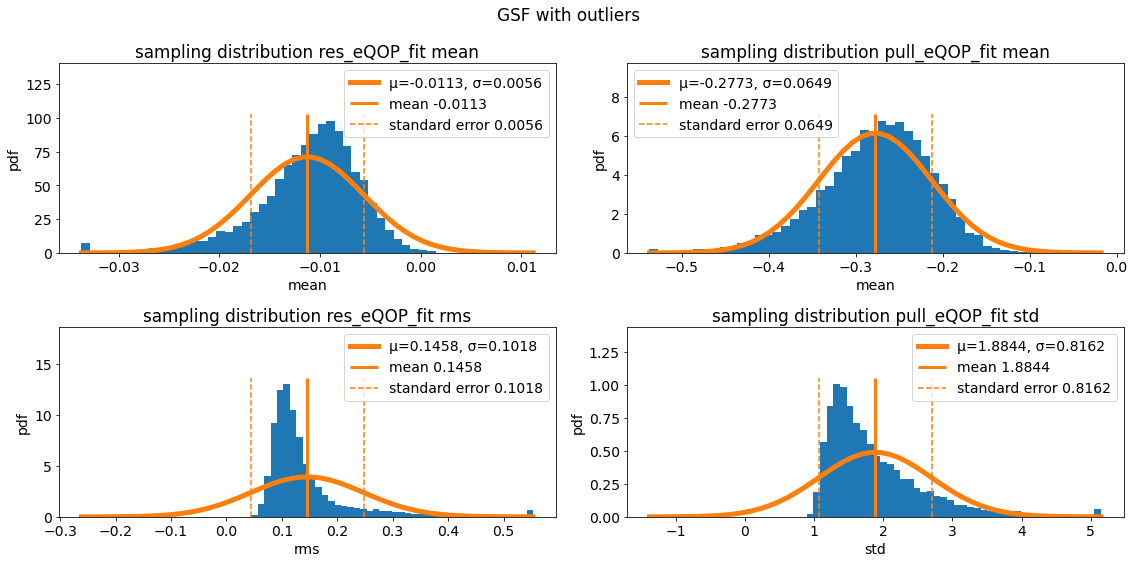

In [82]:
fig, ax = plt.subplots(2,2,figsize=(16,8))

plot_for_stat(summary_long, np.mean, "res_eQOP_fit", fig_ax=(fig, ax[0,0]))
plot_for_stat(summary_long, rms, "res_eQOP_fit", fig_ax=(fig, ax[1,0]))
plot_for_stat(summary_long, np.mean, "pull_eQOP_fit", fig_ax=(fig, ax[0,1]))
plot_for_stat(summary_long, np.std, "pull_eQOP_fit", fig_ax=(fig, ax[1,1]))

fig.suptitle("GSF with outliers")
fig.tight_layout()

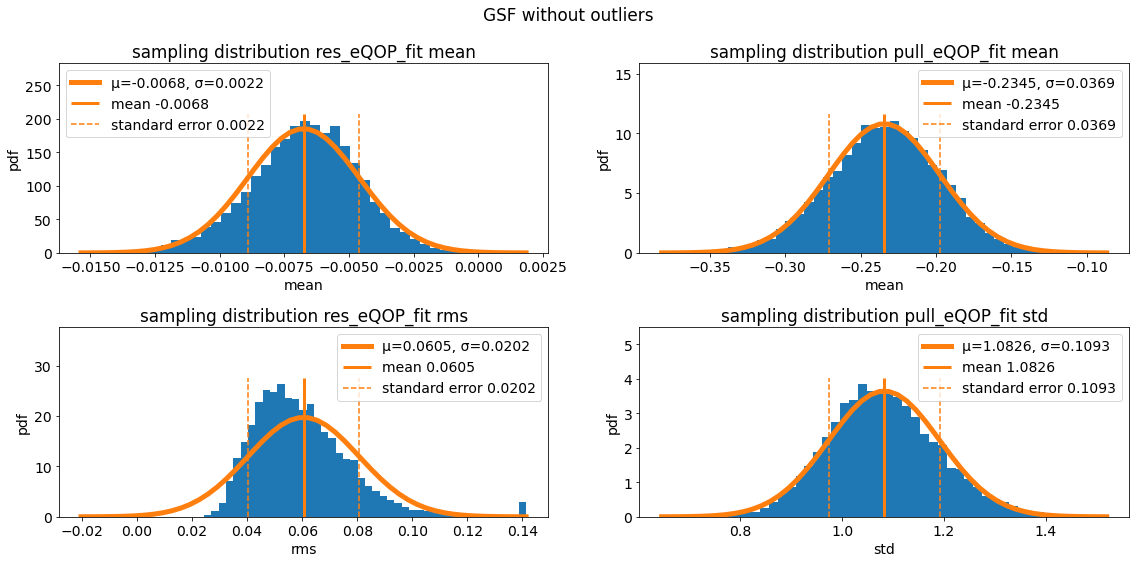

In [83]:
fig, ax = plt.subplots(2,2,figsize=(16,8))

summary_long_no_outliers = summary_long[ summary_long["nOutliers"] == 0 ]
plot_for_stat(summary_long_no_outliers, np.mean, "res_eQOP_fit", fig_ax=(fig, ax[0,0]))
plot_for_stat(summary_long_no_outliers, rms, "res_eQOP_fit", fig_ax=(fig, ax[1,0]))
plot_for_stat(summary_long_no_outliers, np.mean, "pull_eQOP_fit", fig_ax=(fig, ax[0,1]))
plot_for_stat(summary_long_no_outliers, np.std, "pull_eQOP_fit", fig_ax=(fig, ax[1,1]))

fig.suptitle("GSF without outliers")
fig.tight_layout()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:07<00:00,  2.45it/s]


Text(0.5, 0.98, 'GSF (no outliers): res_eQOP_fit')

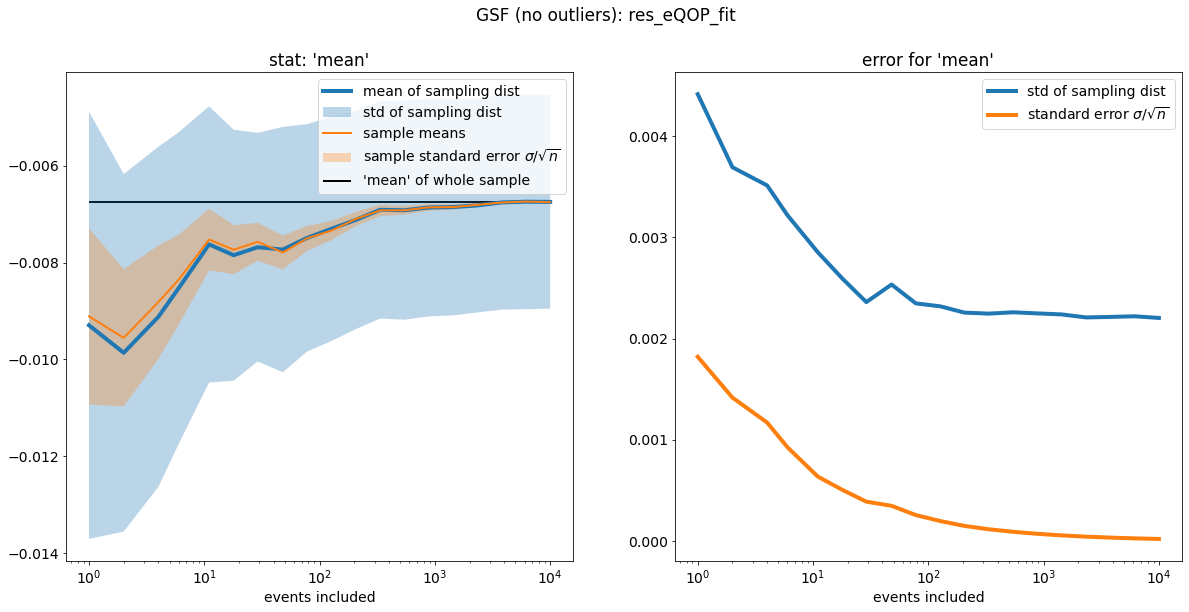

In [87]:
fig, ax = go_through_events(summary_long[ summary_long["nOutliers"] == 0 ], np.mean, "res_eQOP_fit")
fig.suptitle("GSF (no outliers): res_eQOP_fit")

In [78]:
res = bootstrap((summary_long[ summary_long["event_nr"] < 10 ]["res_eQOP_fit"],), np.mean)
res.standard_error

0.0016676615

In [94]:
input_dir_kf = Path("../output/kf/")
summary_long_kf = uproot_to_pandas(uproot.open(str(input_dir_kf / "tracksummary_fitter.root:tracksummary")))

len(summary_long_kf)

9907332

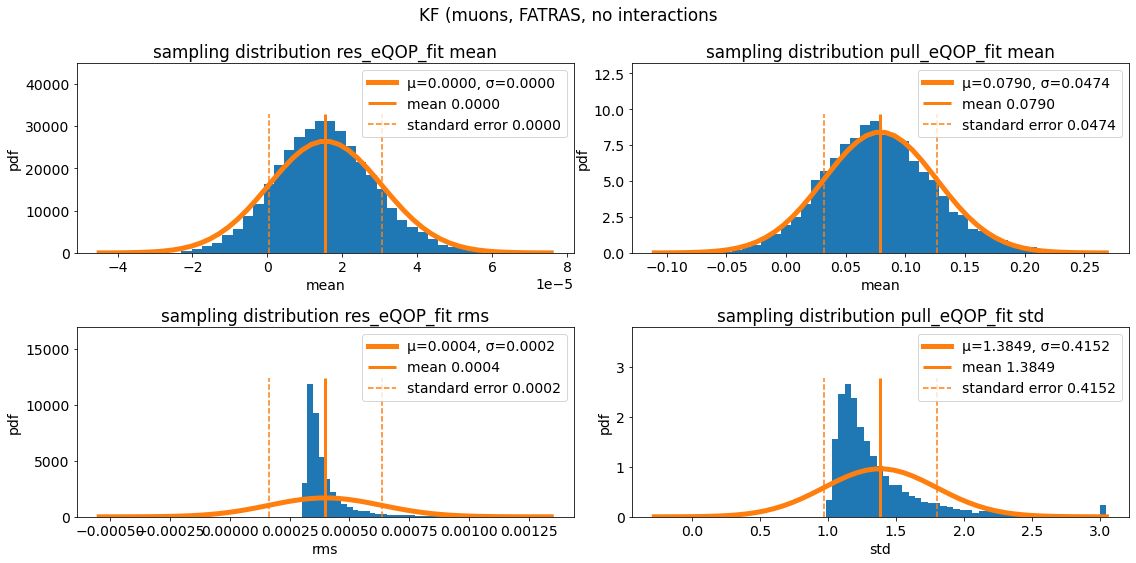

In [95]:
fig, ax = plt.subplots(2,2,figsize=(16,8))

plot_for_stat(summary_long_kf, np.mean, "res_eQOP_fit", fig_ax=(fig, ax[0,0]))
plot_for_stat(summary_long_kf, rms, "res_eQOP_fit", fig_ax=(fig, ax[1,0]))
plot_for_stat(summary_long_kf, np.mean, "pull_eQOP_fit", fig_ax=(fig, ax[0,1]))
plot_for_stat(summary_long_kf, np.std, "pull_eQOP_fit", fig_ax=(fig, ax[1,1]))

fig.suptitle("KF (muons, FATRAS, no interactions")
fig.tight_layout()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:08<00:00,  2.15it/s]


Text(0.5, 0.98, 'KF (muons, FATRAS, no interactions)')

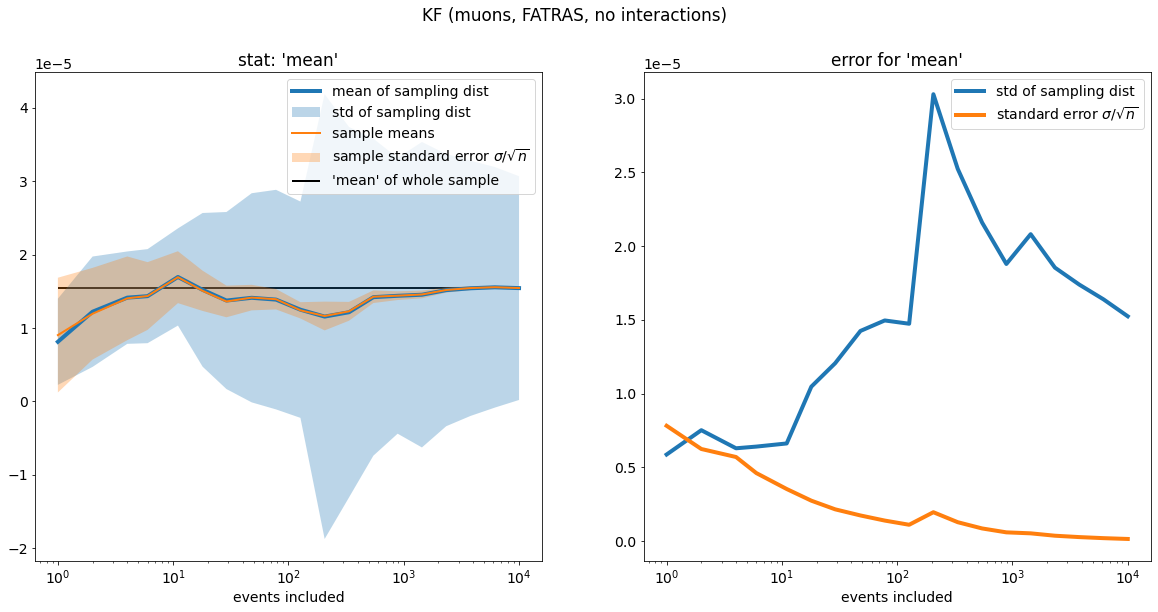

In [96]:
fig, ax = go_through_events(summary_long_kf, np.mean, "res_eQOP_fit")
fig.suptitle("KF (muons, FATRAS, no interactions)")